__Visualized Transformer Attention with DINO__

Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import timm
import dino
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import cv2
import time
import urllib.request
import keyboard

device = torch.device("cpu")

c:\Users\bjohnson\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load ViT Model

In [3]:
#model = timm.create_model('vit_small_patch16_224_dino',pretrained=True)
model = torch.hub.load('facebookresearch/dino:main','dino_vits16')


# Load MiDaS model onto CPU
device = torch.device('cpu')
midas = torch.hub.load("intel-isl/MiDaS","MiDaS_small")
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.small_transform

Using cache found in C:\Users\bjohnson/.cache\torch\hub\facebookresearch_dino_main
Using cache found in C:\Users\bjohnson/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\bjohnson/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\bjohnson/.cache\torch\hub\intel-isl_MiDaS_master


In [19]:
# Setup frame capture
cap = cv2.VideoCapture('video3.mp4') #use video
# cap = cv2.VideoCapture(0) #stream from webcam
previous_frame = None

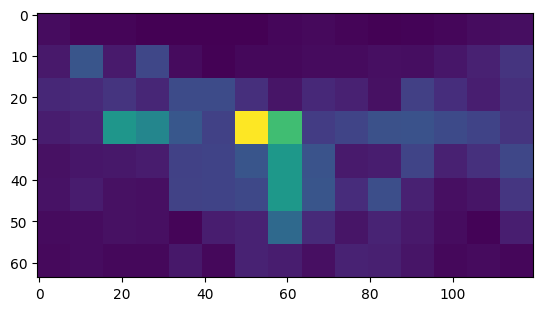

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

In [20]:
attentions_list = []

while True: 
    # Load frame
    ret= cap.grab()
    if ret is False:
        break
    ret, img = cap.retrieve()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.addWeighted(img,1.5,img,0,1)
    
    image = Image.fromarray(img)
    Tx = transforms.Resize((135,240))(image)
    Tx2 = transforms.ToTensor()(Tx).unsqueeze_(0)
    Tx3 = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(Tx2)
    Tx3.requires_grad = True

    # Compute depth
    input_batch = transform(img).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=(180, 320),
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    output = prediction.cpu().numpy()
    depth = cv2.normalize(output, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype = cv2.CV_64F)
    #depth = (depth).astype(np.uint8)
    model.eval()
    model.to(device)

    # start_time = time.time()
    attentions = model.get_last_selfattention(Tx3)
    # print("--- %s seconds ---" % (time.time() - start_time))
    
    nh = attentions.shape[1]
    attentions = attentions[0, :, 0, 1:].reshape(nh,-1)
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    patch_size = 8
    w_featmap = Tx3.shape[-2] // patch_size
    h_featmap = Tx3.shape[-1] // patch_size
    threshold = 0.6 # We visualize masks obtained by thresholding the self-attention maps to keep xx% of the mass.
    th_attn = cumval > (1 - threshold)
    idx2 = torch.argsort(idx)
    for head in range(0,nh):
        th_attn[head] = th_attn[head][idx2[head]]

    th_attn = th_attn.reshape(nh, w_featmap//2, h_featmap//2).float()

    # interpolate
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().numpy()

    attentions = attentions.reshape(nh, w_featmap//2, h_featmap//2)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().numpy()
    attentions_mean = np.mean(attentions, axis=0)
    # if (previous_frame is None):
    #     # First frame; there is no previous one yet
    #     previous_frame = img
    #     continue
    # # calculate difference and update previous frame
    # diff_frame = cv2.absdiff(src1=previous_frame, src2=img)
    # previous_frame = img
    # # 4. Dilute the image a bit to make differences more seeable; more suitable for contour detection
    # kernel = np.ones((5, 5))
    # diff_frame = cv2.dilate(diff_frame, kernel, 1)
    # # 5. Only take different areas that are different enough (>20 / 255)
    # thresh_frame = cv2.threshold(src=diff_frame, thresh=100, maxval=255, type=cv2.THRESH_BINARY)[1]
    # im = cv2.cvtColor(thresh_frame, cv2.COLOR_BGR2GRAY)
    # contours, _ = cv2.findContours(image=im, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    # mini = cv2.resize(depth, (6,4), interpolation = cv2.INTER_AREA)
    attentions_list.append(attentions_mean)

ims = []
figure = plt.figure()

for i in range(0,len(attentions_list)):
    im = plt.imshow(attentions_list[i], animated=True)
    if i == 0:
        plt.imshow(attentions_list[i])
    ims.append([im])


ani = animation.ArtistAnimation(figure, ims, blit=True, interval=50)

plt.show()

writer = animation.FFMpegWriter(fps=15)
ani.save("output.mp4")
